In [1]:
from generate_lung_skeletons.skeleton_generation import (
    add_rotation_to_tree, 
    graph_to_image, 
    dilute_tree_image,
    augment_image,
    add_noise_to_image_surface)

from morphospaces.data.data_utils import (
    draw_line_segment,
    find_indices_within_radius,
)
from numpy.random import default_rng
import random
from scipy.spatial.transform import Rotation as R

from skeletolung.graph_cleanup import napari_plot_graph
from morphospaces.io.hdf5 import write_multi_dataset_hdf
from morphospaces.data.skeleton import compute_skeleton_vector_field,make_segmentation_distance_image, draw_proximal_vector_field, make_proximal_vector_image, make_skeleton_blur_image, make_point_blur, make_skeletonization_target
from generate_lung_skeletons import hdf5
import pickle
import networkx as nx
import skimage
import numpy as np
import napari
import h5py
%reload_ext autoreload
%autoreload 2

In [6]:
with h5py.File('/home/mmederacke/lung_fractal/ml/synthetic_trainings_data/branch_points_elipse/branch_point_elipse_35.h5') as f:
    im = f['raw'][:]
    seg = f['label'][:]
viewer = napari.Viewer()
viewer.add_image(im)
viewer.add_image(seg)

<Image layer 'seg' at 0x7f84d06b3f90>

In [23]:
# lung = nx.read_gpickle("../run/lung_graph2d.pickle")
with open("../run/lung_graph2d.pickle", "rb") as f:
    lung = pickle.load(f)


In [24]:
lung.nodes(data=True)

NodeDataView({-1: {'pos': array([388., 560.,   0.]), 'level': -1}, 0: {'pos': array([388., 400.,   0.]), 'level': 0}, 2: {'pos': array([188., 320.,   0.]), 'level': 1}, 3: {'pos': array([628., 320.,   0.]), 'level': 1}, 4: {'pos': array([ 88., 240.,   0.]), 'level': 2}, 5: {'pos': array([288., 240.,   0.]), 'level': 2}, 6: {'pos': array([528., 240.,   0.]), 'level': 2}, 7: {'pos': array([728., 240.,   0.]), 'level': 2}, 8: {'pos': array([ 38., 160.,   0.]), 'level': 3}, 9: {'pos': array([138., 160.,   0.]), 'level': 3}, 10: {'pos': array([238., 160.,   0.]), 'level': 3}, 11: {'pos': array([338., 160.,   0.]), 'level': 3}, 12: {'pos': array([478., 160.,   0.]), 'level': 3}, 13: {'pos': array([578., 160.,   0.]), 'level': 3}, 14: {'pos': array([678., 160.,   0.]), 'level': 3}, 15: {'pos': array([778., 160.,   0.]), 'level': 3}, 16: {'pos': array([13., 80.,  0.]), 'level': 4}, 17: {'pos': array([63., 80.,  0.]), 'level': 4}, 18: {'pos': array([113.,  80.,   0.]), 'level': 4}, 19: {'pos': 

In [20]:
#add/update node positions
min_x = np.floor(np.min(np.array(list(dict(lung.nodes(data = 'pos')).values()))[:,0]))
min_y = np.floor(np.min(np.array(list(dict(lung.nodes(data = 'pos')).values()))[:,1]))




update_pos = {}
for n in lung.nodes(data ='pos'):
    update_pos[n[0]] = np.array(n[1]) - np.array((min_x, min_y, 0))


ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [ ]:
lungc = lung.copy()


In [22]:
import pandas as pd

def preprocess_graphs(graph:nx.Graph, origin):

    #generate a tree from the graph
    tree = nx.DiGraph(graph)
    tree.remove_edges_from(tree.edges - nx.bfs_edges(tree, origin))

    #label nodes
    new_node_labels = {}
    counter = 0
    lobe_df = pd.DataFrame(columns = ['node', 'lobe','degree','level'])
    for u,v in nx.bfs_edges(tree, origin):
        lobe_df.loc[counter,'start_node'] = int(u)
        lobe_df.loc[counter,'end_node'] = int(v)
        if not new_node_labels.get(u): 
            new_node_labels[u] = "N"+str(counter)
            lobe_df.loc[counter,'node'] = new_node_labels[u]
            if graph.edges[u,v].get('lobe'):
                # lobe_df.loc[counter,'lobe'] = graph.nodes[u]['lobe']
                lobe_df.loc[counter,'lobe'] = graph.edges[u,v]['lobe']
            lobe_df.loc[counter,'degree'] = graph.degree(u)
            lobe_df.loc[counter,'level'] = graph.nodes[u]['level']


            counter += 1

        if not new_node_labels.get(v):
            new_node_labels[v] = "N"+str(counter)
            lobe_df.loc[counter,'node'] = new_node_labels[v]
            if graph.edges[u,v].get('lobe'):
                # lobe_df.loc[counter,'lobe'] = graph.nodes[v]['lobe']
                lobe_df.loc[counter,'lobe'] = graph.edges[u,v]['lobe']
            lobe_df.loc[counter,'degree'] = graph.degree(v)
            lobe_df.loc[counter,'level'] = graph.nodes[v]['level']


            counter += 1


    tree = nx.relabel_nodes(tree, new_node_labels)
    return tree, lobe_df
lung_tree, lobe_df = preprocess_graphs(lung, 0)

def networkx_to_newick(tree, node, parent=None):
    if not list(tree.successors(node)):
        return f"{node}:{tree[parent][node]['length']}" if parent else node
    else:
        children_newick = []
        for child in tree.successors(node):
            children_newick.append(networkx_to_newick(tree, child, node))
        if parent is not None:
            newick = "(" + ",".join(children_newick) + f"){node}:{tree[parent][node]['length']}"
        else:
            newick = "(" + ",".join(children_newick) + ")"
        return newick

newick_tree = networkx_to_newick(lung_tree, 'N0')
from Bio import Phylo
from io import StringIO
from newick import loads
handle = StringIO(newick_tree)
tree = Phylo.read(handle, "newick")
Phylo.write(tree, '/home/mmederacke/lung_fractal/ml/results/simple_tree.nwk', 'newick')




KeyError: 'level'

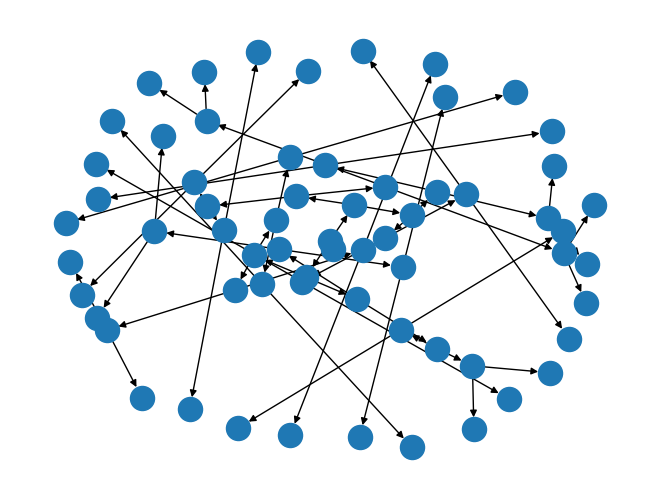

In [15]:
nx.draw(lung)

In [16]:
rot_degree = np.radians(random.sample(list(np.linspace(-30,30,60)),3))
rot_degree


array([0.27511122, 0.41710411, 0.16861655])

In [49]:
#Rotation matrices

rot_degree = np.radians(random.sample(list(np.linspace(-30,30,60)),3))
R_matrix_x = np.matrix(([1,0,0],
                        [0,np.cos(rot_degree[0]),-np.sin(rot_degree[0])],
                        [0,np.sin(rot_degree[0]),np.cos(rot_degree[0])]))

R_matrix_y = np.matrix(([np.cos(rot_degree[1]),0,np.sin(rot_degree[1])],
                        [0,1,0],
                        [-np.sin(rot_degree[1]),0,np.cos(rot_degree[1])]))

R_matrix_z = np.matrix(([np.cos(rot_degree[2]),-np.sin(rot_degree[2]),0],
                        [np.sin(rot_degree[2]),np.cos(rot_degree[2]),0],
                        [0,0,1]))

#Augment tree by rotating it along the trachea
pos = nx.get_node_attributes(lungc, 'pos')

update_pos = {}
for node, node_pos in pos.items():
    root = pos[-1]
    p = node_pos - root
    r_x =R.from_matrix(R_matrix_x) 
    r_y = R.from_matrix(R_matrix_y)
    r_z =R.from_matrix(R_matrix_z)
    p_rot =r_x.apply(p)
    p_rot =r_y.apply(p_rot)
    p_rot =r_z.apply(p_rot)
    p_rot = p_rot + root
    update_pos[node] = p_rot.flatten()
nx.set_node_attributes(lungc, update_pos, name = 'pos')




In [34]:
napari_plot_graph(lung)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [55]:
#rotate tree
add_rotation_to_tree(lungc)
skel_image,branch_point_image,edge_point_image = graph_to_image(lungc)


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [52]:
# viewer = napari.Viewer()
viewer=  napari.current_viewer()
viewer.add_image(skel_image, blending = 'additive', opacity = 0.3)
viewer.add_image(branch_point_image,blending = 'additive')
viewer.add_image(edge_point_image,blending = 'additive')

<Image layer 'edge_point_image' at 0x7fc7585307f0>

In [56]:
rescale_factor = np.array([skel_image.shape[1]/(skel_image.shape[0]), 
                        skel_image.shape[1]/skel_image.shape[1], 
                        skel_image.shape[1]/skel_image.shape[2]])

In [66]:


rescaled_shape= [np.min(skel_image.shape[1])]*3
skel_image = skimage.transform.resize(skel_image,rescaled_shape, order=1)
#add a small boarder, so dilituion doesnt fail at the boundaries
skel_image = np.pad(skel_image, pad_width=50)

In [67]:
skel_image_dils = dilute_tree_image(lungc, skel_image)


[560 400 320 240 160  80   0]
400 560
320 400
240 320
160 240
80 160
0 80


In [78]:
branch_point_image = rotate(branch_point_image,30)
branch_points = np.argwhere(branch_point_image != 0) *rescale_factor
branch_points= branch_points + np.array([50]*3)

edge_point_image = rotate(edge_point_image,30)
edge_points = np.argwhere(edge_point_image != 0) *rescale_factor
edge_points= edge_points + np.array([50]*3)

In [80]:
lungc.nodes()

NodeView((-1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63))

In [81]:
viewer.add_points(branch_points)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<Points layer 'branch_points [2]' at 0x7fc7455cb190>

In [118]:
rot_degree = [-0.5]
rot_axes = [1,0]
rotate(skel_image_dils, rot_degree, axes = rot_axes)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [119]:
skel_image_dils_rotated, branch_point_image_rotated,end_point_image_rotated = augment_image(skel_image_dils,branch_point_image,edge_point_image)

-5.593220338983052 [2, 1]


In [108]:
from scipy.ndimage import rotate
# skel_image_rotated = rotate(skel_image, -30, axes = [1,2])
skel_image_dils_rotated = rotate(skel_image_dils, 30, axes = [1,2])
# branch_point_image_rotated = rotate(branch_points,30)

In [120]:
# viewer = napari.Viewer()
# viewer.add_image(skel_image_dils)
viewer.add_image(skel_image_dils_rotated)
# viewer.add_image(skel_image_rotated)
# viewer.add_image(branch_point_image_rotated)
# viewer.add_image(branch_point_image)


<Image layer 'skel_image_dils_rotated [2]' at 0x7fc6594b76a0>

array([560, 400, 320, 240, 160,  80,   0])

In [121]:
skel_mesh_vox = add_noise_to_image_surface(skel_image_dils, noise_magnitude=13)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


sh: -c: line 0: unexpected EOF while looking for matching ``'
sh: -c: line 1: syntax error: unexpected end of file


In [86]:
vector_skeleton = compute_skeleton_vector_field(skeleton_image = skel_image,segmentation_image = skel_mesh_vox )

branch_point_vector_image= make_proximal_vector_image(
    image_shape = skel_image.shape,
    point_coordinates = branch_points,
    radius = 4
)
end_point_vector_image = make_proximal_vector_image(
    image_shape = skel_image.shape, 
    point_coordinates = edge_points,
    radius = 4,
)
vector_image = np.concatenate(
    (
        vector_skeleton, 
        branch_point_vector_image, 
        end_point_vector_image
    ),
    axis = 0
)
vector_image[:, np.logical_not(skel_mesh_vox)] = 0

segmentation_distance, scaled_background_vector_image = make_segmentation_distance_image(skel_mesh_vox)

rng = default_rng(4)
skeleton_dilation_size = rng.integers(3,10)
skeleton_gaussian_size = int(4)
# skeleton_dilation_size = 7
point_gaussian_size =int(4) 

skeletonization_target = make_skeletonization_target(
    skeleton_image = skel_image, 
    skeleton_gaussian_size=skeleton_gaussian_size,
    skeleton_dilation_size =skeleton_dilation_size, 
    end_points=edge_points.astype(int),
    branch_points = branch_points.astype(int),
    point_gaussian_size = point_gaussian_size
)

In [100]:
skeletonization_target.shape

(3, 590, 590, 590)

<Image layer 'skeletonization_target' at 0x7fbb6336f1c0>